<a href="https://colab.research.google.com/github/Ashish-Abraham/LLM-Boilerplate/blob/main/GPTFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

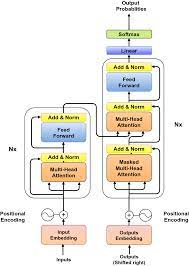

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, attention_dim, bias=False, dropout=0.1):
        super().__init__()
        self.w_key = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.w_query = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.w_value = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, _ = x.size()
        """
        [
            [write vector],
            [me vector],
            [a vector],
            [poem vector],
        ]
        """

        k = self.w_key(x)   # (B, T, A)
        q = self.w_query(x) # (B, T, A)
        v = self.w_value(x) # (B, T, A)

        # Scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # (B, T, T)

        # Causal mask (future positions masked)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-1e10'))

        attn = scores.softmax(dim=-1)  # (B, T, T)

        attn = self.dropout(attn)

        return attn @ v  # (B, T, A)


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, attention_dim, dropout=0.1):
        super().__init__()
        self.head_size = attention_dim//num_heads
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(SelfAttention(embed_dim=embed_dim, attention_dim=self.head_size,dropout=dropout))

    def forward(self,x):
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head(x)) #B x T x A//num_heads
        concatenated = torch.cat(head_outputs, dim = 2)
        return concatenated


In [4]:
class FeedForward(nn.Module):
    def __init__(self,attention_dim):
        super().__init__()
        self.up = nn.Linear(attention_dim,attention_dim*4)
        self.relu = nn.GELU()
        self.down = nn.Linear(attention_dim*4,attention_dim)
    def forward(self,x):
        return self.down(self.relu(self.up(x)))


In [5]:
class Decoder(nn.Module):
    def __init__(self,num_heads,embed_dim,attention_dim, dropout=0.1):
        super().__init__()
        self.masked_multihead = MultiHeadAttention(num_heads, embed_dim, attention_dim, dropout)
        self.feed_forward = FeedForward(attention_dim)
        self.n1 = nn.LayerNorm(attention_dim)
        self.n2 = nn.LayerNorm(attention_dim)
    def forward(self,x):
        e = self.masked_multihead(self.n1(x))
        e =  e + x
        e = self.feed_forward(self.n2(e))
        return e



In [6]:
class GPT(nn.Module):
    def __init__(self, num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, attention_dim)
        self.positional_embedding = nn.Embedding(context_length, attention_dim)

        self.decoders = nn.ModuleList([
            Decoder(num_heads, attention_dim, attention_dim, dropout_rate) for _ in range(num_blocks)
        ])

        self.exit_norm = nn.LayerNorm(attention_dim)
        self.linear = nn.Linear(attention_dim, vocab_size)

    def forward(self, context):
        embeddings = self.embedding(context)
        context_len = context.shape[1]
        position = torch.arange(context_len, device=context.device).unsqueeze(0)
        position_embeddings = self.positional_embedding(position)

        e = embeddings + position_embeddings

        for decoder in self.decoders:
            e = decoder(e)

        return self.linear(self.exit_norm(e))


In [7]:
int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = float('-inf')
    return out


def generate_text(model, new_chars, context, context_length, int_to_char, temperature=1.0, top_k=None):
    res = []
    for _ in range(new_chars):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)
        res.append(int_to_char[next_token.item()])

    return ''.join(res)

def generate(model, max_new_tokens, context, context_length, temperature=1.0, top_k=None):
    res = []
    for _ in range(max_new_tokens):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)


    return context



### GPT2-124M

| Parameter      | Value   | Description                 |
|----------------|---------|-----------------------------|
| `vocab_size`   | 50257   | Vocabulary size             |
| `context_length`| 1024    | Context length              |
| `emb_dim`      | 768     | Embedding dimension         |
| `n_heads`      | 12      | Number of attention heads   |
| `n_layers`     | 12      | Number of layers            |
| `drop_rate`    | 0.1     | Dropout rate                |
| `qkv_bias`     | False   | Query-Key-Value bias        |

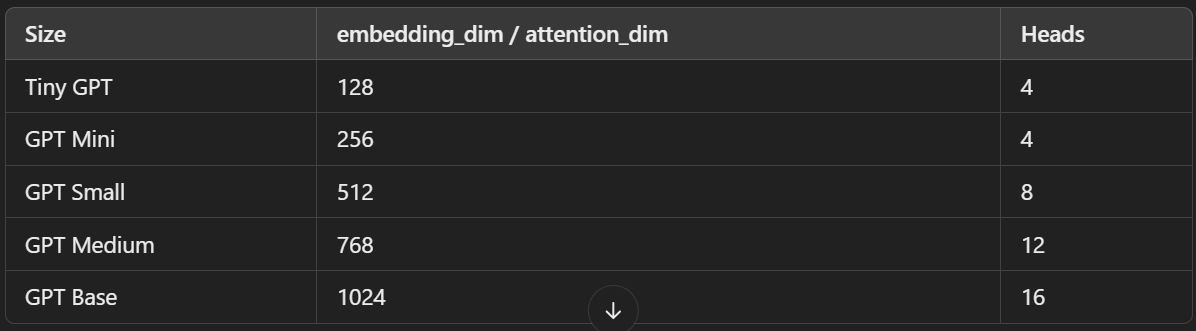

In [8]:
vocab_size = 104             # Number of tokens in your vocabulary
context_length = 128         # Maximum sequence length (tokens)
embed_dim = 256              # Token embedding size
attention_dim = 256          # Attention projection dimension (keep same as embed_dim)
num_heads = 4                # Number of attention heads (must divide attention_dim)
num_blocks = 6               # Number of decoder blocks (layers)
num_words = 5000
dropout_rate=0.1           # Number of new tokens to generate (optional tuning)

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length,dropout_rate).to(device)
model.eval()

GPT(
  (embedding): Embedding(104, 256)
  (positional_embedding): Embedding(128, 256)
  (decoders): ModuleList(
    (0-5): 6 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (w_key): Linear(in_features=256, out_features=64, bias=False)
            (w_query): Linear(in_features=256, out_features=64, bias=False)
            (w_value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=1024, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=1024, out_features=256, bias=True)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear):

In [9]:
# generate_text(model,num_words,context,context_length,int_to_char)

# Train

In [10]:
!pip install datasets

In [11]:
!curl -X GET "https://datasets-server.huggingface.co/rows?dataset=huggingartists%2Fcoldplay&config=default&split=train&offset=0&length=100" -o coldplay_data.json
import json
import pandas as pd

with open('coldplay_data.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['rows'])
display(df.head())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0   231k      0 --:--:-- --:--:-- --:--:--  231k


,row_idx,row,truncated_cells
0,0,{'text': 'Ive been reading books of old The le...,[]
1,1,"{'text': 'Come up to meet you, tell you Im sor...",[]
2,2,{'text': 'I used to rule the world Seas would ...,[]
3,3,"{'text': 'When you try your best, but you dont...",[]
4,4,{'text': 'Look at the stars Look how they shin...,[]


In [12]:
df = df.drop(columns=['truncated_cells'])
df['text'] = df['row'].apply(lambda x: x['text'])
df = df.drop(columns=['row'])
display(df.head())

,row_idx,text
0,0,Ive been reading books of old\nThe legends and...
1,1,"Come up to meet you, tell you Im sorry\nYou do..."
2,2,I used to rule the world\nSeas would rise when...
3,3,"When you try your best, but you dont succeed\n..."
4,4,Look at the stars\nLook how they shine for you...


In [13]:
import re
# Select subsets
train_subset = df.iloc[:90]
test_subset = df.iloc[90:]

# Extract and clean lyrics
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Process training lyrics
train_lyrics = [keep_english_only(row["text"]) for index, row in train_subset.iterrows()]
joined_train_lyrics = '\n'.join(train_lyrics)

# Process test lyrics
test_lyrics = [keep_english_only(row["text"]) for index, row in test_subset.iterrows()]
joined_test_lyrics = '\n'.join(test_lyrics)

full_lyrics = joined_train_lyrics + '\n' + joined_test_lyrics

In [14]:
full_lyrics[:200]

'Ive been reading books of old\nThe legends and the myths\nAchilles and his gold\nHercules and his gifts\nSpider-Mans control\nAnd Batman with his fists\nAnd clearly I dont see myself upon that list\nBut she '

In [15]:
characters = list(set(full_lyrics))
len(characters)

65

## Word Tokenizer

In [16]:
import tiktoken

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer, device):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device) # add batch dimension and move to device
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "I want something"
tokenizer = tiktoken.get_encoding("gpt2")

In [17]:
vocab_size = tokenizer.n_vocab           # Number of tokens in your vocabulary
context_length = 1024        # Maximum sequence length (tokens)
embed_dim = 768              # Token embedding size
attention_dim = 768          # Attention projection dimension (keep same as embed_dim)
num_heads = 12                # Number of attention heads (must divide attention_dim)
num_blocks = 12               # Number of decoder blocks (layers)
num_words = 5000
dropout_rate =0.1           # Number of new tokens to generate (optional tuning)

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length, dropout_rate).to(device)
model.eval()

GPT(
  (embedding): Embedding(50257, 256)
  (positional_embedding): Embedding(128, 256)
  (decoders): ModuleList(
    (0-3): 4 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (w_key): Linear(in_features=256, out_features=64, bias=False)
            (w_query): Linear(in_features=256, out_features=64, bias=False)
            (w_value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=1024, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=1024, out_features=256, bias=True)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear

In [18]:
token_ids = generate(
    model=model,
    context=text_to_token_ids(start_context, tokenizer, device),
    max_new_tokens=10,
    context_length=context_length
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I want something 1907 DurationOne Echoes Colin amongMG praising hopping Rai


### Pretraining

In [34]:
import requests

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
response = requests.get(url)
text_data = response.text

# You can print the first few characters to verify
print(text_data[:500])

# The text data is now ready to be used with the dataloader
# train_dataloader and test_dataloader can be created using this text_data

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



class CustomDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})


        # Use a sliding window to chunk the data into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_encoded_dataloader(txt, tokenizer, batch_size=4, max_length=128,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):

    # Create dataset
    dataset = CustomDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [38]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

# Sanity check

if total_tokens * (0.95) < context_length:
    print("Not enough tokens for the training loader. "
          "Try to lower the context_length or "
          "increase the `training_ratio`")

if total_tokens * (1-0.95) <context_length:
    print("Not enough tokens for the validation loader. "
          "Try to lower the context_length or "
          "decrease the `training_ratio`")

Characters: 20479
Tokens: 5145


In [39]:
# Create training and validation dataloaders
train_dataloader = create_encoded_dataloader(
    text_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=context_length,
    stride=context_length,
    shuffle=True,
    drop_last=True
)

test_dataloader = create_encoded_dataloader(
    text_data,
    tokenizer=tokenizer,
    batch_size=2,
    max_length=context_length,
    stride=context_length,
    shuffle=False,
    drop_last=True
)

print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in validation dataloader: {len(test_dataloader)}")
print("Train loader:")
for x, y in train_dataloader:
    print(x.shape, y.shape)

print("\ntest loader:")
for x, y in test_dataloader:
    print(x.shape, y.shape)

Number of batches in training dataloader: 20
Number of batches in validation dataloader: 20
Train loader:
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])

test loader:
torch.Size([2, 128]) torch.Size([2, 128]

In [40]:
train_tokens = 0
for input_batch, target_batch in train_dataloader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in test_dataloader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 5120
Validation tokens: 5120
All tokens: 10240


In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    # Reshape logits and targets for CrossEntropyLoss
    loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context, context_length, num_chars=100):
    model.eval()
    # Convert start_context to token IDs using the provided function
    context_tensor = text_to_token_ids(start_context, tokenizer, device)

    with torch.no_grad():
        # Generate text using the generate function
        generated_tokens = generate(model, num_chars, context_tensor, context_length=context_length)
        # Decode tokens to text using the provided function
        decoded_text = token_ids_to_text(generated_tokens, tokenizer)

        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
                eval_freq, eval_iter, start_context, tokenizer, context_length, patience=3):

    train_losses, val_losses = [], []
    epochs_seen = []
    tokens_seen = []
    total_tokens = 0
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for i, (input_batch, target_batch) in enumerate(train_loader):
            total_tokens += input_batch.numel()  # Count tokens in the current batch

            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            if (i + 1) % eval_freq == 0 or i == len(train_loader) - 1:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                epochs_seen.append(epoch + (i + 1) / len(train_loader))  # Fractional epoch
                tokens_seen.append(total_tokens)
                print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Optional: Save the best model state
                    # torch.save(model.state_dict(), 'best_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping triggered at epoch {epoch+1}")
                        return train_losses, val_losses, epochs_seen, tokens_seen


        # Generate a sample at the end of each epoch
        print(f"Epoch {epoch+1}/{num_epochs} Sample:")
        generate_and_print_sample(model, tokenizer, device, start_context, context_length)

    return train_losses, val_losses, epochs_seen, tokens_seen

In [46]:
settings = {
    "learning_rate": 5e-4,
    "weight_decay": 0.1,
    "num_epochs" : 1000
}

optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

In [47]:
train_losses, val_losses, epochs_seen, tokens_seen = train_model(
        model, train_dataloader, test_dataloader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=10, eval_iter=1,
        start_context="I want something", tokenizer=tokenizer,
        context_length=context_length
    )

Epoch 1/1000, Step 10/20: Train Loss=6.8913, Val Loss=7.2570
Epoch 1/1000, Step 20/20: Train Loss=6.7052, Val Loss=7.2525
Epoch 1/1000 Sample:
I want something Plex know sitesAll hisestyles stopping weightoutineih very back affordable Willow americ he Subaru away resusc you all I my k sched talk Dak placesight Mead morning Lt,Cat of had up it floating of at I Sach really on one toYeah not me Replacement TV.For see not chem her, laugh him in hery good you scare assumptions isile at the Lord eyes, hands state887 And theupiter glyc Tinker highermm enoughwithout tearsdayName it said line\"> it vegetables found didnt think rock of
Epoch 2/1000, Step 10/20: Train Loss=6.9782, Val Loss=7.2513
Epoch 2/1000, Step 20/20: Train Loss=6.8757, Val Loss=7.2476
Epoch 2/1000 Sample:
I want something takes rather the underest wasFax feet whole-+-+-+-+ was circling ice lions the Martin sandwiches work reflexcould coercive theTPP companies tried, Freemany idle pardon loose=-=-=-=-ium minds him751 wounding

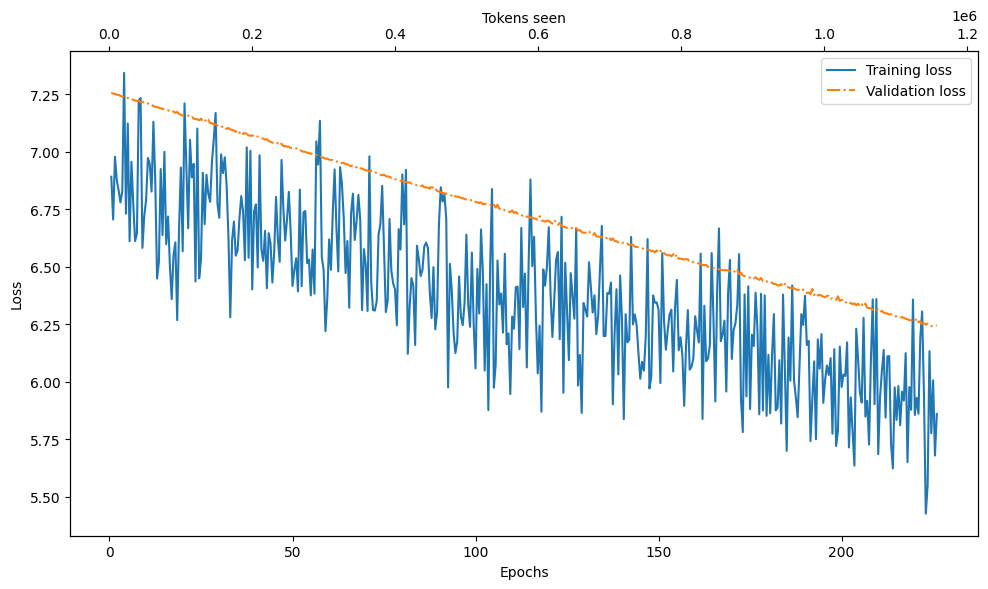

In [48]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

# Assuming train_losses, val_losses, epochs_seen, and tokens_seen are returned from the training function
# Plot the losses
plot_losses(epochs_seen, tokens_seen, train_losses, val_losses)

### Finetune On ColdPlay

In [ ]:
# Create training and validation dataloaders for finetuning on Coldplay lyrics (character level)
finetune_train_dataloader = create_encoded_dataloader(
    joined_train_lyrics,
    tokenizer=char_to_int, # Using the character tokenizer
    batch_size=32,
    max_length=context_length,
    stride=context_length,
    shuffle=True,
    drop_last=True
)

finetune_test_dataloader = create_encoded_dataloader(
    joined_test_lyrics,
    tokenizer=char_to_int, # Using the character tokenizer
    batch_size=32,
    max_length=context_length,
    stride=context_length,
    shuffle=False,
    drop_last=True
)

# Define finetuning settings (can be different from pretraining)
finetune_settings = {
    "learning_rate": 0.0001,  # Often lower for finetuning
    "weight_decay": 1e-2,
    "num_epochs": 100,      # Fewer epochs than pretraining
    "eval_freq": 10,
    "eval_iter": 5,
    "start_context": "I want something", # Starting text for finetuning generation
}

# Re-initialize optimizer for finetuning (optional, but often done)
finetune_optimizer = torch.optim.AdamW(
    model.parameters(), lr=finetune_settings["learning_rate"], weight_decay=finetune_settings["weight_decay"]
)

# Start finetuning
finetune_train_losses, finetune_val_losses, finetune_epochs_seen, finetune_tokens_seen = train_model(
    model,
    finetune_train_dataloader,
    finetune_test_dataloader,
    finetune_optimizer,
    device,
    num_epochs=finetune_settings["num_epochs"],
    eval_freq=finetune_settings["eval_freq"],
    eval_iter=finetune_settings["eval_iter"],
    start_context=finetune_settings["start_context"],
    tokenizer=char_to_int, # Use the character tokenizer for finetuning
    context_length=context_length
)

# Plot finetuning losses (optional)
# plot_losses(finetune_epochs_seen, finetune_tokens_seen, finetune_train_losses, finetune_val_losses)

## Character Tokenizer

In [ ]:
int_to_char = {}
for i, char in enumerate(characters):
    int_to_char[i] = char

char_to_int = {}

for value, char  in int_to_char.items():
    char_to_int[char] = value

print(int_to_char,char_to_int,end="\t")

{0: 'd', 1: '7', 2: 'E', 3: 'v', 4: 'g', 5: 'r', 6: 'D', 7: ',', 8: 's', 9: '3', 10: 'V', 11: 'J', 12: 'F', 13: ' ', 14: '2', 15: 'L', 16: 'a', 17: 'j', 18: 'X', 19: 'T', 20: '(', 21: 'm', 22: 'R', 23: '5', 24: '?', 25: '}', 26: '_', 27: 'c', 28: '8', 29: '6', 30: 'U', 31: 'Q', 32: '{', 33: 't', 34: 'W', 35: ';', 36: '/', 37: '4', 38: 'i', 39: 'u', 40: '1', 41: 'h', 42: 'C', 43: '-', 44: '&', 45: 'x', 46: 'G', 47: '$', 48: 'q', 49: '.', 50: '%', 51: 'w', 52: '9', 53: '#', 54: 'o', 55: ':', 56: 'n', 57: '+', 58: 'K', 59: '\n', 60: 'f', 61: 'Z', 62: 'b', 63: 'l', 64: 'e', 65: 'z', 66: 'I', 67: 'p', 68: 'P', 69: 'N', 70: 'M', 71: '@', 72: '0', 73: 'y', 74: 'Y', 75: 'A', 76: 'S', 77: 'k', 78: 'B', 79: 'O', 80: '!', 81: ')', 82: 'H'} {'d': 0, '7': 1, 'E': 2, 'v': 3, 'g': 4, 'r': 5, 'D': 6, ',': 7, 's': 8, '3': 9, 'V': 10, 'J': 11, 'F': 12, ' ': 13, '2': 14, 'L': 15, 'a': 16, 'j': 17, 'X': 18, 'T': 19, '(': 20, 'm': 21, 'R': 22, '5': 23, '?': 24, '}': 25, '_': 26, 'c': 27, '8': 28, '6': 29, 

In [ ]:


encoded_train = [char_to_int[c] for c in joined_train_lyrics if c in char_to_int]

encoded_test = [char_to_int[c] for c in joined_test_lyrics if c in char_to_int]

print(len(encoded_train),len(encoded_test))

320566 83790


In [ ]:

# context_length=3
# encoded= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

def create_dataset(encoded, context_length=128):
  inputs, targets = [], []
  for i in range(len(encoded) - context_length):
    inputs.append(encoded[i:i+context_length])
    targets.append(encoded[i+1:i+context_length+1])
  return torch.tensor(inputs), torch.tensor(targets)

train_inputs, train_targets = create_dataset(encoded_train)
test_inputs, test_targets = create_dataset(encoded_test)



In [ ]:
from torch.utils.data import TensorDataset, DataLoader


def train(model):
  vocab_size = len(char_to_int)
  context_length = 128
  embed_dim = 128
  attention_dim = 128
  num_heads = 4
  num_blocks = 6
  epochs = 40
  lr = 0.001
  patience = 3
  batch_size = 32


  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
  best_loss = float('inf')
  patience_counter = 0
  losses, accuracies = [],[]

  train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=batch_size)


  for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      pred = model(X)
      pred_flat = pred.view(-1, vocab_size)
      y_flat = y.view(-1)
      loss = loss_func(pred_flat, y_flat)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      predictions = pred_flat.argmax(dim=1)
      correct += (predictions == y_flat).sum().item()
      total += y_flat.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)
    # Evaluation
    model.eval()
    eval_loss = 0
    with torch.no_grad():
      for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        pred_flat = pred.view(-1, vocab_size)
        y_flat = y.view(-1)
        loss = loss_func(pred_flat, y_flat)
        eval_loss += loss.item()
    eval_loss /= len(test_loader)
    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Eval Loss={eval_loss:.4f}")
    if avg_loss < best_loss:
      best_loss = avg_loss
      patience_counter = 0
      best_model_state = model.state_dict()
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break
  return model, epoch+1, losses, accuracies


In [ ]:
vocab_size = 83
context_length = 128
embed_dim = 128
attention_dim = 128
num_heads = 4
num_blocks = 6

model = GPT(num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length).to(device)
#model.load_state_dict(torch.load("/content/trained_model-128-85.pth", weights_only=False))

model,epochs,losses,accuracies = train(model)
# Save the trained model
model_path = "trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


from google.colab import files
files.download('trained_model.pth')

Epoch 1: Train Loss=2.9923, Accuracy=0.1847, Eval Loss=2.9766
Epoch 2: Train Loss=2.5018, Accuracy=0.2728, Eval Loss=2.1993
Epoch 3: Train Loss=1.7594, Accuracy=0.4696, Eval Loss=1.7817
Epoch 4: Train Loss=1.3911, Accuracy=0.5753, Eval Loss=1.6761
Epoch 5: Train Loss=1.2424, Accuracy=0.6198, Eval Loss=1.6222
Epoch 6: Train Loss=1.1552, Accuracy=0.6459, Eval Loss=1.5853
Epoch 7: Train Loss=1.0940, Accuracy=0.6643, Eval Loss=1.5758
Epoch 8: Train Loss=1.0484, Accuracy=0.6778, Eval Loss=1.5480


### Cross Entropy
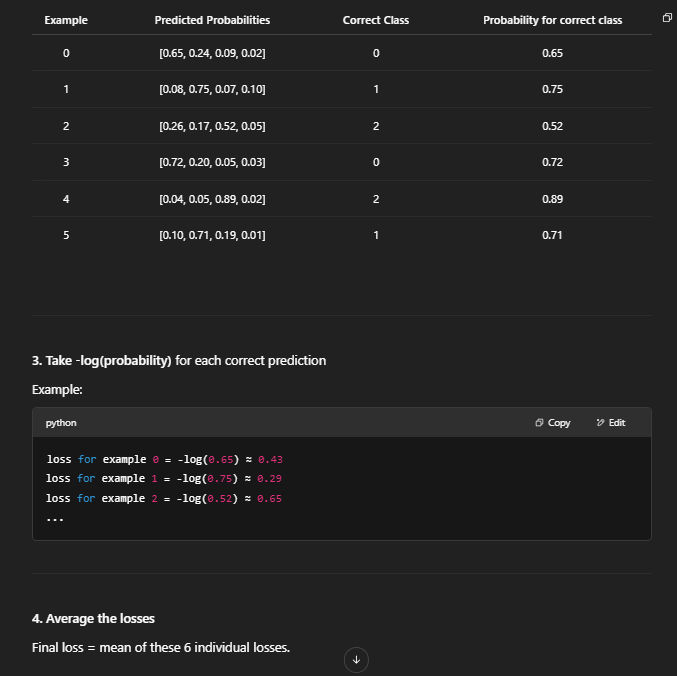

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# Training parameters
num_epochs = 10
eval_freq = 50  # Evaluate every 50 batches
eval_iter = 5   # Evaluate on 5 batches for training and validation loss calculation
learning_rate = 0.001
start_context = "The" # Starting text for generation

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Start training
train_losses, val_losses = train_model(
    model, train_dataloader, test_dataloader, optimizer, device,
    num_epochs, eval_freq, eval_iter, start_context, tokenizer, context_length
)